In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [2]:
from importlib import reload
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
from tqdm.auto import tqdm, trange
import mmcv
import data
import bbox
from utils import imshownp
import utils
import meva
from meva.lib.meva_model import MEVA
from meva.utils import kp_utils
from meva.utils import image_utils
from meva.utils.video_config import update_cfg
from torch.utils.data import DataLoader
import joblib
import scipy.ndimage

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [3]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [6]:
c = data.ClimbingDataset('val', seq_len=90)

In [80]:
pretrained_file = f"results/meva/train_meva_2/model_best.pth.tar"
config_file = f"meva/cfg/train_meva_2.yml"
cfg = update_cfg(config_file)

In [81]:
batch_size = 6
model = MEVA(
    n_layers=cfg.MODEL.TGRU.NUM_LAYERS,
    batch_size=batch_size,
    seqlen=cfg.DATASET.SEQLEN,
    hidden_size=cfg.MODEL.TGRU.HIDDEN_SIZE,
    add_linear=cfg.MODEL.TGRU.ADD_LINEAR,
    bidirectional=cfg.MODEL.TGRU.BIDIRECTIONAL,
    use_residual=cfg.MODEL.TGRU.RESIDUAL,
    cfg=cfg.VAE_CFG,
)
ckpt = torch.load(pretrained_file, map_location='cpu')
# print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
model.load_state_dict(ckpt)
model.eval()

loading VAErecV2 model from checkpoint: results/meva/vae_rec_2/models/model_1000.p


MEVA(
  (vae_model): VAErecV2(
    (e_rnn): RNN(
      (rnn_f): GRUCell(144, 256)
      (rnn_b): GRUCell(144, 256)
    )
    (e_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (e_mu): Linear(in_features=512, out_features=512, bias=True)
    (e_logvar): Linear(in_features=512, out_features=512, bias=True)
    (d_rnn): RNN(
      (rnn_f): GRUCell(656, 512)
    )
    (d_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (d_out): Linear(in_features=512, out_features=144, bias=True)
    (init_pose_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (init_p

In [84]:
params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
params, trainable

(64975949, 58737965)

In [134]:
batch_size=6
dataloader = DataLoader(c, batch_size=batch_size, num_workers=0, shuffle = False)

In [135]:
import time
output = {}
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, norm_joints2d = [], [], [], [], [], []
for seqs in iter(dataloader):
    with torch.no_grad():
        start = time.time()
        feats = seqs['features']
        output = model(feats)[-1]
        finish = time.time()
        pred_cam.append(output['theta'][:, :, :3])
        pred_verts.append(output['verts'])
        pred_pose.append(output['theta'][:, :, 3:75])
        pred_betas.append(output['theta'][:, :, 75:])
        pred_joints3d.append(output['kp_3d'])
        norm_joints2d.append(output['kp_2d'])
    break
pred_cam = torch.cat(pred_cam, dim=0)
pred_verts = torch.cat(pred_verts, dim=0)
pred_pose = torch.cat(pred_pose, dim=0)
pred_betas = torch.cat(pred_betas, dim=0)
pred_joints3d = torch.cat(pred_joints3d, dim=0)
norm_joints2d = torch.cat(norm_joints2d, dim=0)

pred_cam = pred_cam.cpu().numpy()
pred_verts = pred_verts.cpu().numpy()
pred_pose = pred_pose.cpu().numpy()
pred_betas = pred_betas.cpu().numpy()
pred_joints3d = pred_joints3d.cpu().numpy()
norm_joints2d = norm_joints2d.cpu().numpy()
output_dict = {'pred_cam': pred_cam,
               'verts': pred_verts,
               'pose': pred_pose,
               'betas': pred_betas,
               'joints3d': pred_joints3d,
               'joints2d': norm_joints2d}

In [ ]:
res = output_dict

In [136]:
(finish-start)*len(c)/batch_size

131.89726448059082

In [8]:
res_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = joblib.load(f'{res_folder}/{vid_name}.pkl')

In [17]:
res.keys()

dict_keys(['pred_cam', 'verts', 'pose', 'betas', 'joints3d', 'joints2d'])

In [18]:
seqidx = 2
frameid = 50
seqinfo = c.get(seqidx)

/home/tormod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


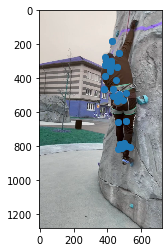

In [29]:
inv_trans = seqinfo['inv_trans'][frameid].copy()
kp_2d = res['joints2d'][seqidx, frameid].copy()
#kp_2d *= 1.2
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
kp_2d = image_utils.trans_points2d(kp_2d, inv_trans)
plt.imshow(seqinfo['raw_imgs'][frameid])
plt.scatter(kp_2d[:,0], kp_2d[:,1])
plt.show();

[0.6886164  0.01665802 0.26140934]


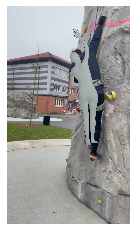

In [28]:
import mesh
reload(mesh)
reload(meva.utils.demo_utils)
verts = res['verts'][seqidx, frameid].copy()
cam = res['pred_cam'][seqidx, frameid].copy()
bboxes = seqinfo['bboxes'][frameid:].copy()
img = seqinfo['raw_imgs'][frameid].copy()
print(cam)
cam[0] *= 1.2
imshownp(mesh.render_pred_mesh(img, bboxes, verts, cam), bgr=True)

# Render Results

In [57]:
from meva.utils.renderer import Renderer
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
def render_vids(cd, res, out_folder, vid_idx):
    vid = cd.vids[vid_idx]
    vid_name = data.stripped_names[vid_idx]
    cd.load_labels(vid_name)
    bboxes = cd.bboxes[vid_name]
    orig_width, orig_height = vid.resolution
    renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
    vertss = res['verts']
    vertss = vertss.reshape(-1, vertss.shape[-2], vertss.shape[-1])
    pred_cams = res['pred_cam']
    pred_cams = pred_cams.reshape(-1, pred_cams.shape[-1])
    for frame in trange(len(vertss)):
        img = vid[frame]
        verts = vertss[frame]
        pred_cam = pred_cams[np.newaxis, frame].copy()
        pred_cam[:, 0] *= 1.2
        bbox = bboxes[np.newaxis, frame]
        orig_cam = convert_crop_cam_to_orig_img(
            pred_cam, bbox, orig_width, orig_height)[0]
        mesh_img = renderer.render(img, verts, orig_cam)
        
        black_img = renderer.render(np.zeros_like(img), verts, orig_cam)  
        
        out_img = np.concatenate([black_img, mesh_img], axis=1)
        mmcv.imwrite(out_img, f'{out_folder}/{vid_name}/{frame:06d}.png')

    mmcv.frames2video(f'{out_folder}/{vid_name}', f'{out_folder}/{vid_name}.mp4',
                      filename_tmpl='{:06d}.png')

In [58]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
cd = data.ClimbingDataset('all', video_folder=vid_folder)

In [59]:
vid_names = ['IMG_2139', 'IMG_2320', 'IMG_2304', 'IMG_2306', 'IMG_2314', 'IMG_2315']

## Pre-trained

In [93]:
in_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'
out_folder = '/media/tormod/Den Lille/Thesis/pretrained_meva_results'
for vid_name in vid_names: 
    res = joblib.load(f'{in_folder}/{vid_name}.pkl')
    vid_idx = data.stripped_names.index(vid_name)
    render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6750/6750, 28.0 task/s, elapsed: 241s, ETA:     0s


/home/tormod/Documents/APEC/meva/utils/image_utils.py:384: RuntimeWarning: invalid value encountered in double_scalars
  w = h = np.where(w / h > 1, w, h)


/home/tormod/Documents/APEC/meva/utils/demo_utils.py:163: RuntimeWarning: divide by zero encountered in true_divide
  sx = cam[:, 0] * (1. / (img_width / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  sy = cam[:, 0] * (1. / (img_height / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:165: RuntimeWarning: divide by zero encountered in true_divide
  tx = ((cx - hw) / hw / sx) + cam[:, 1]
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:166: RuntimeWarning: divide by zero encountered in true_divide
  ty = ((cy - hh) / hh / sy) + cam[:, 2]
/home/tormod/Documents/APEC/meva/utils/renderer.py:31: RuntimeWarning: invalid value encountered in float_scalars
  P[0, 3] = self.translation[0] * self.scale[0]
/home/tormod/Documents/APEC/meva/utils/renderer.py:32: RuntimeWarning: invalid value encountered in float_scalars
  P[1, 3] = -self.translation[1] * self.scale[1]



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7560/7560, 13.2 task/s, elapsed: 571s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 720/720, 12.7 task/s, elapsed: 57s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 630/630, 14.1 task/s, elapsed: 45s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1260/1260, 13.7 task/s, elapsed: 92s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 180/180, 15.2 task/s, elapsed: 12s, ETA:     0s


## Climb-trained

In [94]:
in_folder = '/home/tormod/ucph-erda-home/climb_meva_results'
out_folder = '/media/tormod/Den Lille/Thesis/climb_meva_results'
for vid_name in vid_names: 
    res = joblib.load(f'{in_folder}/{vid_name}.pkl')
    vid_idx = data.stripped_names.index(vid_name)
    render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6750/6750, 27.6 task/s, elapsed: 245s, ETA:     0s


/home/tormod/Documents/APEC/meva/utils/image_utils.py:384: RuntimeWarning: invalid value encountered in double_scalars
  w = h = np.where(w / h > 1, w, h)


/home/tormod/Documents/APEC/meva/utils/demo_utils.py:163: RuntimeWarning: divide by zero encountered in true_divide
  sx = cam[:, 0] * (1. / (img_width / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  sy = cam[:, 0] * (1. / (img_height / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:165: RuntimeWarning: divide by zero encountered in true_divide
  tx = ((cx - hw) / hw / sx) + cam[:, 1]
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:166: RuntimeWarning: divide by zero encountered in true_divide
  ty = ((cy - hh) / hh / sy) + cam[:, 2]
/home/tormod/Documents/APEC/meva/utils/renderer.py:31: RuntimeWarning: invalid value encountered in float_scalars
  P[0, 3] = self.translation[0] * self.scale[0]
/home/tormod/Documents/APEC/meva/utils/renderer.py:32: RuntimeWarning: invalid value encountered in float_scalars
  P[1, 3] = -self.translation[1] * self.scale[1]



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7560/7560, 13.3 task/s, elapsed: 567s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 720/720, 12.7 task/s, elapsed: 57s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 630/630, 13.1 task/s, elapsed: 48s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1260/1260, 13.6 task/s, elapsed: 93s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 180/180, 15.2 task/s, elapsed: 12s, ETA:     0s


## MEVA30

In [61]:
in_folder = '/home/tormod/ucph-erda-home/meva30_results'
out_folder = '/media/tormod/Den Lille/Thesis/meva30_results'
for vid_name in vid_names: 
    res = joblib.load(f'{in_folder}/{vid_name}.pkl')
    vid_idx = data.stripped_names.index(vid_name)
    render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6810/6810, 27.5 task/s, elapsed: 248s, ETA:     0s


/home/tormod/Documents/APEC/meva/utils/image_utils.py:384: RuntimeWarning: invalid value encountered in double_scalars
  w = h = np.where(w / h > 1, w, h)


/home/tormod/Documents/APEC/meva/utils/demo_utils.py:163: RuntimeWarning: divide by zero encountered in true_divide
  sx = cam[:, 0] * (1. / (img_width / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  sy = cam[:, 0] * (1. / (img_height / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:165: RuntimeWarning: divide by zero encountered in true_divide
  tx = ((cx - hw) / hw / sx) + cam[:, 1]
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:166: RuntimeWarning: divide by zero encountered in true_divide
  ty = ((cy - hh) / hh / sy) + cam[:, 2]
/home/tormod/Documents/APEC/meva/utils/renderer.py:31: RuntimeWarning: invalid value encountered in float_scalars
  P[0, 3] = self.translation[0] * self.scale[0]
/home/tormod/Documents/APEC/meva/utils/renderer.py:32: RuntimeWarning: invalid value encountered in float_scalars
  P[1, 3] = -self.translation[1] * self.scale[1]



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7560/7560, 13.4 task/s, elapsed: 563s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 720/720, 14.6 task/s, elapsed: 49s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 630/630, 13.9 task/s, elapsed: 45s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1290/1290, 14.9 task/s, elapsed: 87s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 240/240, 14.7 task/s, elapsed: 16s, ETA:     0s


## MEVA30-Climb

In [62]:
in_folder = '/home/tormod/ucph-erda-home/meva30_climb_results'
out_folder = '/media/tormod/Den Lille/Thesis/meva30_climb_results'
for vid_name in vid_names: 
    res = joblib.load(f'{in_folder}/{vid_name}.pkl')
    vid_idx = data.stripped_names.index(vid_name)
    render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6810/6810, 27.0 task/s, elapsed: 252s, ETA:     0s


/home/tormod/Documents/APEC/meva/utils/image_utils.py:384: RuntimeWarning: invalid value encountered in double_scalars
  w = h = np.where(w / h > 1, w, h)


/home/tormod/Documents/APEC/meva/utils/demo_utils.py:163: RuntimeWarning: divide by zero encountered in true_divide
  sx = cam[:, 0] * (1. / (img_width / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:164: RuntimeWarning: divide by zero encountered in true_divide
  sy = cam[:, 0] * (1. / (img_height / h))
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:165: RuntimeWarning: divide by zero encountered in true_divide
  tx = ((cx - hw) / hw / sx) + cam[:, 1]
/home/tormod/Documents/APEC/meva/utils/demo_utils.py:166: RuntimeWarning: divide by zero encountered in true_divide
  ty = ((cy - hh) / hh / sy) + cam[:, 2]
/home/tormod/Documents/APEC/meva/utils/renderer.py:31: RuntimeWarning: invalid value encountered in float_scalars
  P[0, 3] = self.translation[0] * self.scale[0]
/home/tormod/Documents/APEC/meva/utils/renderer.py:32: RuntimeWarning: invalid value encountered in float_scalars
  P[1, 3] = -self.translation[1] * self.scale[1]



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7560/7560, 13.3 task/s, elapsed: 569s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 720/720, 14.6 task/s, elapsed: 49s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 630/630, 14.5 task/s, elapsed: 44s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1290/1290, 14.6 task/s, elapsed: 88s, ETA:     0s



[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 240/240, 12.9 task/s, elapsed: 19s, ETA:     0s


# Eval Results

In [69]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
def eval_res(split, seq_len=90):
    cd = data.ClimbingDataset(split, seq_len=seq_len, video_folder=vid_folder, preload_all=True)
    current_vid_name = ''
    res = []
    scores, acc_errs = [], []
    cd_range = range(len(cd))    
    for seqidx in tqdm(cd_range):
        seq_info = cd.get(seqidx, get_imgs=False)
        vid_idx, _, vid_seq_idx = cd.get_indices(seqidx, vid_seq=True)
        inv_trans = seq_info['inv_trans']
        vid_name = data.stripped_names[vid_idx]
        if vid_name != current_vid_name:
            res = joblib.load(f'{in_folder}/{vid_name}.pkl')
            current_vid_name = vid_name
        scales = seq_info['bboxes'][:,-1]
        scales = np.clip(scales, 1, max(1, scales.max()))
        frames = seq_info['frames']
        pred_seq = res['joints2d'][vid_seq_idx].copy()
        gt_seq = seq_info['kp_2d']
        oks_score = utils.oks(pred_seq, gt_seq, scales, inv_trans)
        acc_err = utils.acc_error(pred_seq, gt_seq, scales, inv_trans)
        if split in ['test', 'val', 'testval']:
            pred_extra_seq = get_extra_joints(res, vid_seq_idx)

            gt_extra_seq = seq_info['kp_2d_extra'][:,utils.climb_feet_and_hands,:]
            oks_extra = utils.oks_extra(pred_extra_seq, gt_extra_seq, scales, inv_trans)
            oks_score = np.concatenate((oks_score, oks_extra), axis=1)
            
            acc_extra = utils.acc_error_extra(pred_extra_seq, gt_extra_seq, scales, inv_trans)
            acc_err = np.concatenate((acc_err, acc_extra), axis=1)
        scores.append(oks_score)
        acc_errs.append(acc_err)
    scores = np.stack(scores)
    scores = scores.reshape(-1, scores.shape[-1])
    # delete values for eye joints
    scores = np.delete(scores, 1, 1)
    scores = np.delete(scores, 1, 1)
    
    acc_errs = np.stack(acc_errs)
    acc_errs = acc_errs.reshape(-1, acc_errs.shape[-1])
    return scores, acc_errs

def score_per_frame(oks_score, savename=None):
    conv_N = 2*90
    smooth_oks_score = scipy.ndimage.convolve(oks_score, np.ones((conv_N, 1))/conv_N, mode='mirror')
    plt.plot(smooth_oks_score.mean(axis=1))
    plt.ylim((0,1))
    plt.ylabel('OKS')
    plt.xlabel('frames')
    if savename:
        plt.savefig(savename, bbox_inches='tight', dpi=100)
    
def score_per_joint_per_frame(oks_score, savename=None):
    colors = cm.tab20(np.linspace(0,1,19))
    coco_joint_names = kp_utils.get_coco_joint_names()
    coco_joint_names = coco_joint_names[:1] + coco_joint_names[3:]
    climb_names = np.array(data.get_climb_joint_names())[utils.climb_feet_and_hands]
    coco_joint_names = coco_joint_names + list(climb_names)
    conv_N = 2*90
    for j in range(oks_score.shape[1]):
        j_oks = oks_score[:,j].copy()
        j_oks = scipy.ndimage.convolve(j_oks, np.ones(conv_N)/conv_N, mode='mirror')
        plt.plot(j_oks, label=coco_joint_names[j], color=colors[j])
    plt.legend(loc='lower left', ncol=2)
    plt.ylim((0,1))
    plt.ylabel('OKS')
    plt.xlabel('frames')
    if savename:
        plt.savefig(savename, bbox_inches='tight', dpi=100)

def get_extra_joints(r, vid_seq_idx):
    v = r['verts'][vid_seq_idx].copy()
    pc = r['pred_cam'][vid_seq_idx].copy()
    smpl_joints2d = utils.get_extra_joints(v, pc)
    return smpl_joints2d

## MEVA90

In [70]:
model_name = 'meva90'
in_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'

In [71]:
oks_testval, acc_err_testval = eval_res('testval')

In [14]:
oks_test, acc_err_test = eval_res('test')

In [15]:
oks_val, acc_err_val = eval_res('val')

In [21]:
oks_train, acc_err_train = eval_res('train')

In [22]:
print(oks_test.mean(), np.abs(acc_err_test).mean())
print(oks_val.mean(), np.abs(acc_err_val).mean())
print(oks_train.mean(), np.abs(acc_err_train).mean())

0.8440500871443093 0.005483083500152427
0.8192902766803526 0.005596153258747958
0.720537889344089 5.7565023598250535


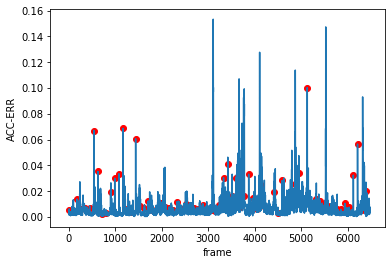

In [99]:
plt.plot(np.abs(acc_err_testval).mean(axis=1))
x = np.arange(0,len(acc_err_testval), 90)
plt.scatter(x, np.abs(acc_err_testval[::90]).mean(axis=1), c='r')
plt.xlabel('frame')
plt.ylabel('ACC-ERR')
plt.savefig(f'{model_name}-acc-err.png', bbox_inches='tight', dpi=100)

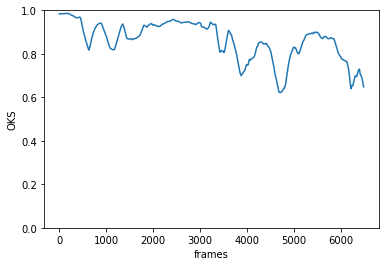

In [38]:
score_per_frame(oks_testval, savename=f'{model_name}-oks.png')

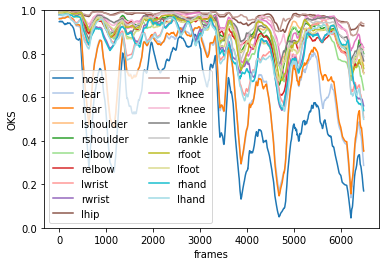

In [39]:
score_per_joint_per_frame(oks_testval, savename=f'{model_name}-oks-joints.png')

## MEVA90-Climb

In [100]:
in_folder = '/home/tormod/ucph-erda-home/climb_meva_results'
model_name = 'meva90-climb'

In [101]:
oks_testval, acc_err_testval = eval_res('testval')

In [49]:
oks_test, acc_err_test = eval_res('test')

In [50]:
oks_val, acc_err_val = eval_res('val')

In [51]:
oks_train, acc_err_train = eval_res('train')

/home/tormod/Documents/APEC/meva/utils/image_utils.py:384: RuntimeWarning: invalid value encountered in double_scalars
  w = h = np.where(w / h > 1, w, h)


In [52]:
print(oks_test.mean(), np.abs(acc_err_test).mean())
print(oks_val.mean(), np.abs(acc_err_val).mean())
print(oks_train.mean(), np.abs(acc_err_train).mean())

0.863175042674077 0.00424992837148769
0.8394697727093642 0.0043689545534744915
0.7259864342091382 5.687542136779535


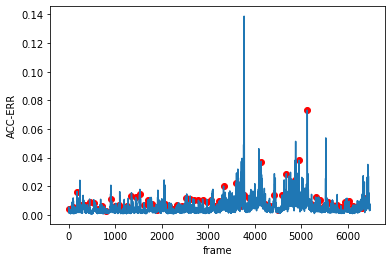

In [102]:
plt.plot(np.abs(acc_err_testval).mean(axis=1))
x = np.arange(0,len(acc_err_testval), 90)
plt.scatter(x, np.abs(acc_err_testval[::90]).mean(axis=1), c='r')
plt.xlabel('frame')
plt.ylabel('ACC-ERR')
plt.savefig(f'{model_name}-acc-err.png', bbox_inches='tight', dpi=100)

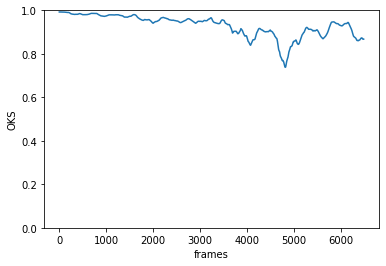

In [43]:
score_per_frame(oks_testval, savename=f'{model_name}-oks.png')

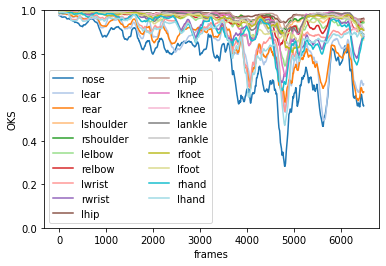

In [44]:
score_per_joint_per_frame(oks_testval, savename=f'{model_name}-oks-joints.png')

## MEVA30

In [110]:
in_folder = '/home/tormod/ucph-erda-home/meva30_results'
model_name = 'meva30'

In [111]:
oks_testval, acc_err_testval = eval_res('testval', seq_len=30)

In [5]:
oks_test, acc_err_test = eval_res('test', seq_len=30)

In [6]:
oks_val, acc_err_val = eval_res('val', seq_len=30)

In [7]:
oks_train, acc_err_train = eval_res('train', seq_len=30)

/home/tormod/Documents/APEC/meva/utils/image_utils.py:384: RuntimeWarning: invalid value encountered in double_scalars
  w = h = np.where(w / h > 1, w, h)


In [8]:
print(oks_test.mean(), np.abs(acc_err_test).mean())
print(oks_val.mean(), np.abs(acc_err_val).mean())
print(oks_train.mean(), np.abs(acc_err_train).mean())

0.8443064472140422 0.0046204196722089905
0.820541334807389 0.004651433592616701
0.7213425684504409 5.787386533656486


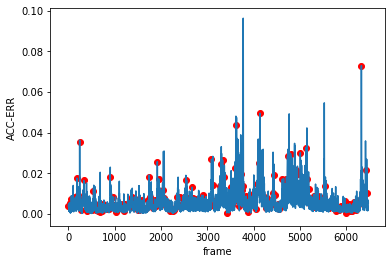

In [112]:
plt.plot(np.abs(acc_err_testval).mean(axis=1))
x = np.arange(0,len(acc_err_testval), 30)
plt.scatter(x, np.abs(acc_err_testval[::30]).mean(axis=1), c='r')
plt.xlabel('frame')
plt.ylabel('ACC-ERR')
plt.savefig(f'{model_name}-acc-err.png', bbox_inches='tight', dpi=100)

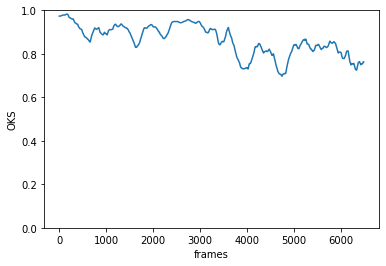

In [48]:
score_per_frame(oks_testval, savename=f'{model_name}-oks.png')

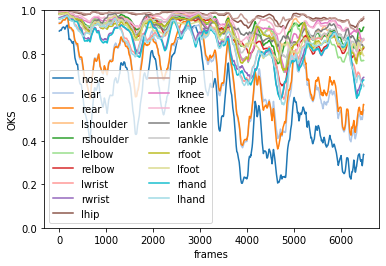

In [49]:
score_per_joint_per_frame(oks_testval, savename=f'{model_name}-oks-joints.png')

## MEVA30-Climb

In [106]:
in_folder = '/home/tormod/ucph-erda-home/meva30_climb_results'
model_name = 'meva30-climb'

In [107]:
oks_testval, acc_err_testval = eval_res('testval', seq_len=30)

In [10]:
oks_test, acc_err_test = eval_res('test', seq_len=30)

In [11]:
oks_val, acc_err_val = eval_res('val', seq_len=30)

In [12]:
oks_train, acc_err_train = eval_res('train', seq_len=30)

In [13]:
print(oks_test.mean(), np.abs(acc_err_test).mean())
print(oks_val.mean(), np.abs(acc_err_val).mean())
print(oks_train.mean(), np.abs(acc_err_train).mean())

0.8656981238572614 0.004997153609721262
0.842293444939705 0.005068651379467726
0.7280871427344568 5.7523756448376995


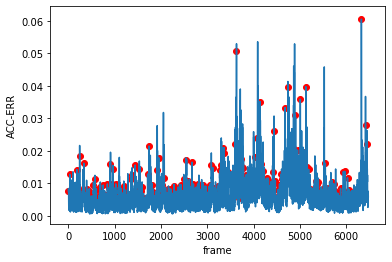

In [109]:
plt.plot(np.abs(acc_err_testval).mean(axis=1))
x = np.arange(0,len(acc_err_testval), 30)
plt.scatter(x, np.abs(acc_err_testval[::30]).mean(axis=1), c='r')
plt.xlabel('frame')
plt.ylabel('ACC-ERR')
plt.savefig(f'{model_name}-acc-err.png', bbox_inches='tight', dpi=100)

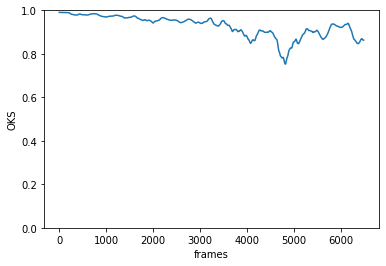

In [53]:
score_per_frame(oks_testval, savename=f'{model_name}-oks.png')

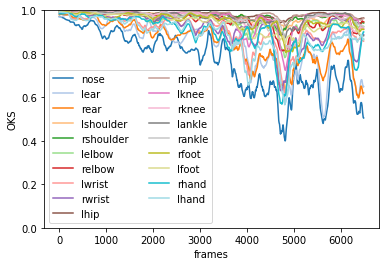

In [54]:
score_per_joint_per_frame(oks_testval, savename=f'{model_name}-oks-joints.png')

# Loss graphs

In [51]:
import re
import matplotlib.pyplot as plt
import numpy as np
def get_meva_losses(in_file):
    val_kpl, train_kpl, okss, train_loss = [], [], [], []
    for l in open(in_file):
        m1 = re.search(r'Epoch (.+), KP_LOSS: (.+), OKS_SCORE: (.+),', l)
        m2 = re.search(r'loss: (\S+) \| loss_kp_2d: (\S+)', l)
        if m1:
            epoch, kp, oks = m1.groups()
            val_kpl.append(float(kp))
            okss.append(float(oks))    
        if m2:
            loss, kp = m2.groups()
            train_loss.append(float(loss))
            train_kpl.append(float(kp))
    val_kpl, okss = np.array(val_kpl),  np.array(okss)
    train_loss, train_kpl = np.array(train_loss), np.array(train_kpl)
    return val_kpl, okss, train_loss, train_kpl

def get_meva_3d_losses(in_file):
    mpjpes, pampjpes, accels, pves, accel_errs = [],[],[],[],[]
    losss, loss_kp_2ds, loss_kp_3ds = [],[],[]
    for l in open(in_file):
        m1 = re.search(r'Epoch (.+), MPJPE: (\S+), PA-MPJPE: (\S+), ACCEL: (\S+), PVE: (\S+), ACCEL_ERR: (\S+),', l)
        m2 = re.search(r'loss: (\S+) \| loss_kp_2d: (\S+) \| loss_kp_3d: (\S+)', l)
        if m1:
            _, mpjpe, pampjpe, accel, pve, accel_err = m1.groups()
            mpjpes.append(float(mpjpe))
            pampjpes.append(float(pampjpe))
            accels.append(float(accel))
            pves.append(float(pve))
            accel_errs.append(float(accel_err))
        if m2:
            loss, loss_kp_2d, loss_kp_3d = m2.groups()
            losss.append(float(loss))
            loss_kp_2ds.append(float(loss_kp_2d))
            loss_kp_3ds.append(float(loss_kp_3d))
                
    out_dict = {'mpjpe': np.array(mpjpes), 
                 'pampjpe': np.array(pampjpes), 
                 'accel': np.array(accels),
                 'pve': np.array(pves),
                 'accel_err': np.array(accel_errs),
                 'loss_kp_2d': np.array(loss_kp_2ds),
                 'loss_kp_3d': np.array(loss_kp_3ds),
                 'loss': np.array(losss)}
    return out_dict

In [53]:
in_file = '/home/tormod/cluster/APEC/results/meva/train_meva_climb/train_log.txt'
val_kpl, okss, train_loss, train_kpl = get_meva_losses(in_file)

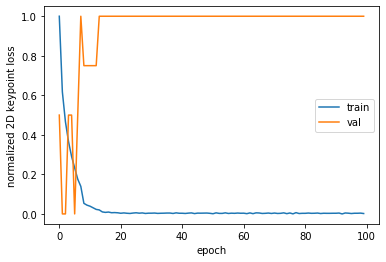

In [54]:
plt.plot((train_loss-train_loss.min())/(train_loss-train_loss.min()).max())
plt.plot((val_kpl-val_kpl.min())/(val_kpl-val_kpl.min()).max())
plt.legend(('train', 'val'))
plt.ylabel('normalized 2D keypoint loss')
plt.xlabel('epoch')
plt.savefig('climb-loss.png', bbox_inches='tight', dpi=100)

In [49]:
in_file = '/home/tormod/cluster/APEC/results/meva/train_meva_all_vae30/train_log.txt'
outs = get_meva_3d_losses(in_file)

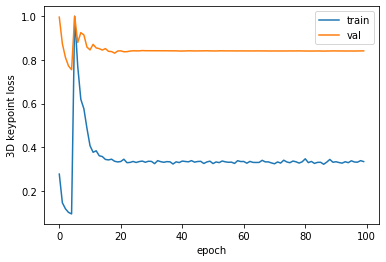

In [50]:
plt.plot(outs['loss']/outs['loss'].max())
plt.plot(outs['mpjpe']/outs['mpjpe'].max())
plt.ylabel('3D keypoint loss')
plt.xlabel('epoch')
plt.legend(('train', 'val'))
plt.savefig('meva30-loss.png', bbox_inches='tight', dpi=100)
plt.show()

In [55]:
in_file = '/home/tormod/cluster/APEC/results/meva/train_meva_climb_vae30/train_log.txt'
val_kpl, okss, train_loss, train_kpl = get_meva_losses(in_file)

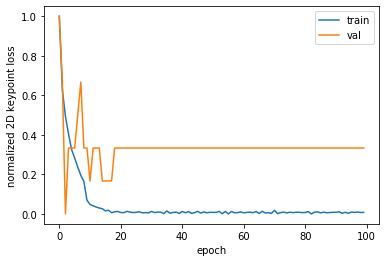

In [56]:
plt.plot((train_loss-train_loss.min())/(train_loss-train_loss.min()).max())
plt.plot((val_kpl-val_kpl.min())/(val_kpl-val_kpl.min()).max())
plt.legend(('train', 'val'))
plt.ylabel('normalized 2D keypoint loss')
plt.xlabel('epoch')
plt.savefig('meva30-climb-loss.png', bbox_inches='tight', dpi=100)

In [120]:
def vae_losses(in_file):
    mses, mse_rts, klds = [], [], []
    for l in open(in_file):
        m1 = re.search(r'MSE: (\S+) MSE_RT: (\S+) KLD: (\S+)', l)
        if m1:
            mse, mse_rt, kld = m1.groups()
            mses.append(float(mse))
            mse_rts.append(float(mse_rt))
            klds.append(float(kld))
    mses, mse_rts, klds = np.array(mses), np.array(mse_rts), np.array(klds)
    return mses, mse_rts, klds

In [121]:
in_file = '/home/tormod/cluster/APEC/results/meva/apec_vae_rec_1/log/log.txt'
mse, mse_rt, kld = vae_losses(in_file)

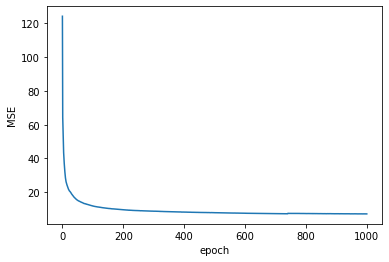

In [127]:
plt.plot(mse)
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('vae30-mse.png', bbox_inches='tight', dpi=100)

In [125]:
kld.argmin()

15

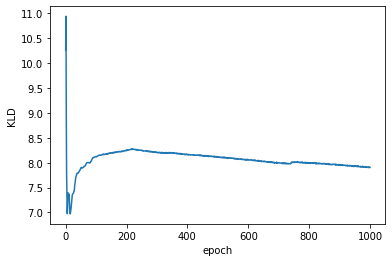

In [124]:
plt.plot(kld)
plt.ylabel('KLD')
plt.xlabel('epoch')
plt.savefig('vae30-kld.png', bbox_inches='tight', dpi=100)